# Setup

In [1]:
%pip install imageio
%pip install pyvirtualdisplay
%pip install tf-agents
%pip install pyglet
%pip install matplotlib
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

# Seed for PPO actor network
import tensorflow_probability as tfp

# PPO Agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.agents.ppo import ppo_actor_network
from tf_agents.networks import value_network
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.ppo import ppo_clip_agent

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.networks import sequential

# old agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network


from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

2022-12-17 16:22:10.076673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Hyperparameters

In [3]:

# register(
#     id='CartPole-v1',
#     entry_point='gym.envs.classic_control:CartPoleEnv',
#     max_episode_steps=500,
#     reward_threshold=475.0,
# )

env_name = "CartPole-v1" # @param {type:"string"}
num_iterations = 5000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 100  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (64,64)

batch_size = 128  # @param {type:"integer"}
learning_rate = 3e-4  # @param {type:"number"}
gamma = 0.99


log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


actor_fc_layers = (8,16,32,64,128,64,32,16,8,4,2)
value_fc_layers = (8,16,32,64,128,64,128,64,32,16,8,4,2)

# Environment

In [4]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

observation_tensor_spec = tensor_spec.from_spec(train_env.observation_spec())
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
time_step_tensor_spec = tensor_spec.from_spec(train_env.time_step_spec())

In [5]:
print('Observation: {0}'.format(observation_tensor_spec))
print('Action: {0}'.format(action_tensor_spec))
print('TimeStep: {0}'.format(time_step_tensor_spec))

Observation: BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32))
Action: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))
TimeStep: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


# Agent

Netowork

In [6]:
actor_fc_layers = (64,64)
value_fc_layers = (64, 64)


actor_net = actor_distribution_network.ActorDistributionNetwork(
        observation_tensor_spec,
        action_tensor_spec,
        fc_layer_params=actor_fc_layers,
        activation_fn=tf.keras.activations.tanh,
        kernel_initializer=tf.keras.initializers.Orthogonal(seed=1),
        seed_stream_class=tfp.util.SeedStream
)

value_net = value_network.ValueNetwork(
    observation_tensor_spec,
    fc_layer_params=value_fc_layers,
    activation_fn=tf.keras.activations.tanh,
    kernel_initializer=tf.keras.initializers.Orthogonal()
)

Optimizer

In [7]:
print(observation_tensor_spec)
print(action_tensor_spec)
print(time_step_tensor_spec)

BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32))
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))
TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [8]:
learning_rate = 3e-4
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
epsilon = 0.2
discount = 0.99
gae_lambda = 0.95
train_step_counter = tf.Variable(0)

agent_ppo = ppo_clip_agent.PPOClipAgent(
    time_step_spec=time_step_tensor_spec,
    action_spec=action_tensor_spec,
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    use_gae=True,
    lambda_value=gae_lambda,
    importance_ratio_clipping=epsilon,
    # log_prob_clipping=epsilon,
    # gradient_clipping=epsilon,
    # value_clipping=epsilon,
    train_step_counter=train_step_counter,
)
agent_ppo.initialize()

2022-12-17 16:22:15.754206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ribeirg/Documents/pessoal/tg/git/learning-tg-agents/venvIntelliJ/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


# Metrics and Evaluation

In [9]:
train_env.current_time_step()

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.04596459, -0.04368313,  0.04124061,  0.04081279]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [10]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

random_policy = random_tf_policy.RandomTFPolicy(
    time_step_tensor_spec,
    action_tensor_spec,
    info_spec=time_step_tensor_spec)

def evaluate_policy(policy):
  for _ in range(1):
    avg= compute_avg_return(eval_env, policy, num_eval_episodes)
    print(avg)

# evaluate_policy(random_policy)

# evaluate_policy(agent_ppo.policy)

evaluate_policy(agent_ppo.collect_policy)


17.0


# Data Collection

In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent_ppo.collect_policy.trajectory_spec,
    batch_size=1,
    max_length=10000)
    # max_length=10000)


def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    replay_buffer.add_batch(traj)
    # print(next_time_step.reward)


for _ in range(initial_collect_steps):
    collect_step(train_env, agent_ppo.collect_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(batch_size)

iterator = iter(dataset)

# print(f'TimeStep: {train_env.time_step_spec()}')
# print(f'Action: {train_env.action_spec()}')
# print(f'Agent: {agent_ppo.collect_policy.time_step_spec}')

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Training the Agent

In [15]:
try:
  %%time
except:
  pass

num_iterations = 1000
collect_steps_per_iteration = 1
eval_interval = 10
num_eval_episodes = 10


# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent_ppo.train = common.function(agent_ppo.train)

# Reset the train step
agent_ppo.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent_ppo.collect_policy, num_eval_episodes)
returns = [avg_return]
returns

for _ in range(num_iterations):
  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent_ppo.collect_policy)
  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent_ppo.train(experience).loss
  # experience, unused_info = next(iterator)
  # train_loss = agent_ppo.train(experience).loss


  step = agent_ppo.train_step_counter.numpy()

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent_ppo.policy, num_eval_episodes)
    print('step = {0}: loss = {1}  AVG RETURN: {2:2f}'.format(step, train_loss, avg_return))
    returns.append(avg_return)


step = 50: loss = 88.1902847290039  AVG RETURN: 500.000000
step = 100: loss = 78.51990509033203  AVG RETURN: 495.200012
step = 150: loss = 82.6442642211914  AVG RETURN: 500.000000
step = 200: loss = 89.36605072021484  AVG RETURN: 500.000000
step = 250: loss = 85.83831024169922  AVG RETURN: 495.700012
step = 300: loss = 87.60682678222656  AVG RETURN: 500.000000
step = 350: loss = 88.50658416748047  AVG RETURN: 499.700012
step = 400: loss = 74.34912872314453  AVG RETURN: 500.000000
step = 450: loss = 94.97447204589844  AVG RETURN: 500.000000
step = 500: loss = 85.76362609863281  AVG RETURN: 500.000000
step = 550: loss = 76.45671844482422  AVG RETURN: 497.299988
step = 600: loss = 65.9117431640625  AVG RETURN: 483.299988
step = 650: loss = 69.25669860839844  AVG RETURN: 495.600006
step = 700: loss = 88.40122985839844  AVG RETURN: 493.799988
step = 750: loss = 86.21687316894531  AVG RETURN: 496.299988
step = 800: loss = 69.6532974243164  AVG RETURN: 500.000000
step = 850: loss = 76.0781326

# Visualization

(459.8899871826172, 510.0)

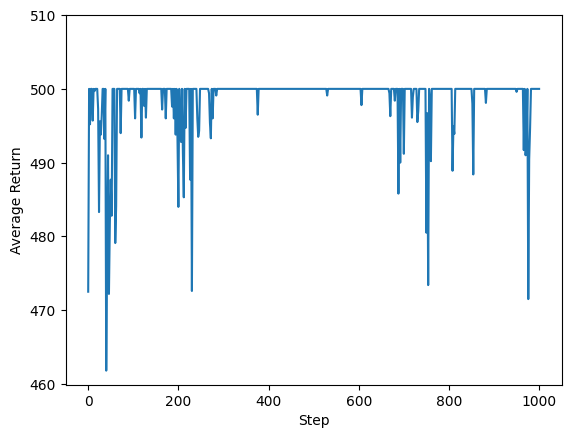

In [17]:
steps = range(0, num_iterations + 1, 2)
# steps = range(0, num_iterations + 1, 10)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=max(returns) + 10)